<a href="https://colab.research.google.com/github/ektamistry/ekta/blob/main/SignalImageProcessing_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


###Project Topic: **Image Hashing and Matching**

#Introduction:
Image hashing is the process of using an algorithm to assign a unique hash value to an image. Duplicate copies of the image all have the exact same hash value. For this reason, it is sometimes referred to as a 'digital fingerprint'.

Images that look identical to us, can be very different if you will just compare the raw bytes. This can be due to:



*   resizing
*   rotation
*   slightly different color gamma
*   different format
*   some minor noise, watermarks and artifacts




Even if you will find an image that will be different just in one byte, if you will apply a hash function to it, the result can be very different (for hashes like MD5, SHA it most probably will be completely different).

***Our main topic for today will be dHash.***

**So what is dHash?**
It’s a visual hash which can be used to quickly find similar pictures. A dhash is a differential gradient hash that compares the difference in gradient between adjacent pixels, and provides a 64 bit hash signature of an image.

So how does this process work?
The idea behind this is that you take any picture, change the image to gray scale, resize it, then a hash algorithm is used to identify the file based on the aforementioned process.

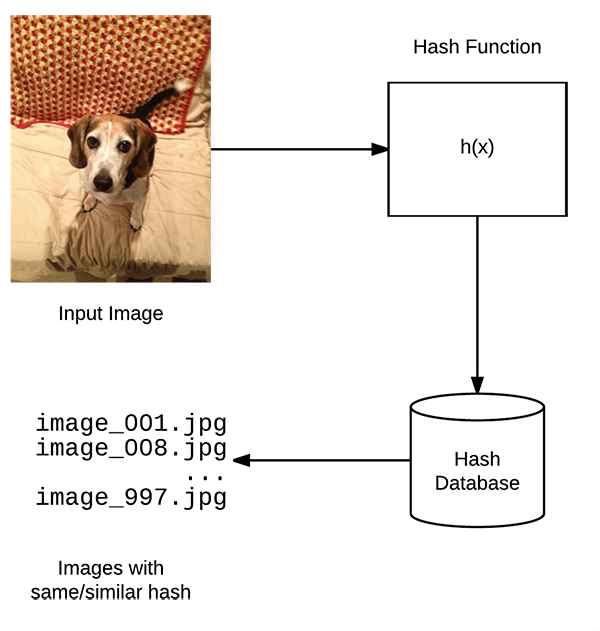


In [ ]:
#Importing the required libraries.
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline 
import cv2
import os  # os lib provides a portable way of using operating system dependent functionality like to open path, create a file etc.
import time
import scipy #scientific python library that uses NumPy underneath

In [ ]:
IMAGE_DIR = '/content/Test' #location of image directory containing all images
img_dupe = '/content/Exp_6.jpg' #image being tested for duplication
img=os.listdir()        #to get the list of all files and directories in the specified directory
os.chdir(IMAGE_DIR)   #to change the current working directory to specified path
os.getcwd()    #returns a string which represents the current working directory of a process

'/content/Test'

In [ ]:
image_files = os.listdir() #to get the list of all files and directories in the specified directory
print(len(image_files))

97


In [ ]:
img2=cv2.imread(img_dupe) #loading the test imaage.

rotated_90_clockwise = np.rot90(img2) #rotated 90 deg once 
rotated_180_clockwise = np.rot90(rotated_90_clockwise)  #rotated 90 deg second time =180
rotated_270_clockwise = np.rot90(rotated_180_clockwise)  #rotated 90 deg third time = 270


cv2.imwrite('/content/one_rot.jpg', rotated_90_clockwise) #saving all the 3 pictures into the files section.
cv2.imwrite('/content/two_rot.jpg', rotated_180_clockwise)
cv2.imwrite('/content/three_rot.jpg', rotated_270_clockwise)

img_f='/content/one_rot.jpg'    #saving the paths of the image
img_s='/content/two_rot.jpg'
img_t='/content/three_rot.jpg'


#This is done so that our algorithm can detect duplicate  images even if they are rotated. 

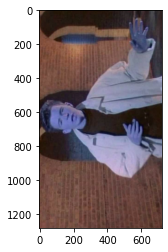

In [ ]:
tem=cv2.imread(img_dupe)
plt.imshow(tem)

In [ ]:
image_files[0] #displaying the first image in list

'20210425_112515.jpg'

In [ ]:
cv2.imread(image_files[0]).shape #displaying image shape

(2119, 3835, 3)

In [ ]:
cv2.imread(image_files[0]).shape[2]  #reading and displaying alpha channel of image from shape 
                                      #( where shape[0] = rows, shape[1]= cols shape[2]= channel ) 
                                      #Channels is 3 for RGB images and 1 for grayscale images

3

In [ ]:
#defining a function to check for non rgb images
def filter_images(images):          
    image_list = []
    for image in images:
        try:
           #testing if image's second element has intensity 3 (rgb)
            assert cv2.imread(image).shape[2] == 3   #Assert is used to continue the execution even if the given condition evaluates to True
            image_list.append(image)
            #displaying error as e
        except  AssertionError as e:
            print(e)
    return image_list



```
!
```



In [ ]:
#turning image into gray scale using  luminosity method and using weighs red, green and blue 
                              #according to their wavelengths formula imgGray = 0.299 * R + 0.587 * G + 0.114 * B
def img_gray(image):
    image = cv2.imread(image)
    return np.average(image, weights=[0.299, 0.587, 0.114], axis=2)

In [ ]:
#resize image to 9x9 using cv2.inter_area and flattening it to one layer
#for row and column individually
def resize(image, height=9, width=9):                                                     
    row_res = cv2.resize(image,(height, width), interpolation = cv2.INTER_AREA).flatten()  #Image interpolation tries to attain a best estimation of a pixel's intensity 
                                                                                            #based on neighboring pixel values on proximity basis.
                                                                                             #When shrinking img interarea is useful as its used in resampling using pixel area relation
    col_res = cv2.resize(image,(height, width), interpolation = cv2.INTER_AREA).flatten('F')
    return row_res, col_res

In [ ]:
#np.diff does out[i] = arr[i+1] – arr[i] i.e intensity  pixel in 2nd row - pixel in 1st row
#taking difference in intensity row wise and column wise
def intensity_diff(row_res, col_res):
    difference_row = np.diff(row_res)
    difference_col = np.diff(col_res)
    
    #difference being non-negative and non zero
    difference_row = difference_row > 0
    difference_col = difference_col > 0

    #stacking the row and intensity differences and flattening the stacked image
    return np.vstack((difference_row, difference_col)).flatten()

In [ ]:
#Calling all the functions filter images, image gray, resize,intensity diffrence and putting them into one function.

def difference_score(image, height = 30, width = 30): #Function is used to calulate the score of how different the images are. Passing image as param
    gray = img_gray(image)                #Take the image and transform it into a gray image
    row_res, col_res = resize(gray, height, width)  #Resizing the gray image to height and width
    difference = intensity_diff(row_res, col_res)     #Taking the intensity diffrence of row res and col res and return it
    
    return difference       



```
!
```



In [ ]:
def hashd(image):
        difference = image
        # 1 => 8, 8 => 16
        decimal_value = 0
        hash_string = ""
        for index, value in enumerate(difference):        #Enumerate() method adds a counter to an iterable and returns it in a form of enumerating object.
            if value:
                decimal_value += value * (2 ** (index % 8))   #in general, computing index mod 8 is a relatively expensive operation. However, if m=2p is a power of two
            if index % 8 == 7:
                # hex() function converts the specified number into a hexadecimal value and we skip starting addr 0x
                hash_string += str(hex(decimal_value)[2:].rjust(2, "0"))  #rjust() method will right align the string arg (len,char)
                decimal_value = 0
        return hash_string

In [ ]:
def difference_score_dict_hash(image_list):
    ds_dict = {}  #making a dictionary  to store keys as the hash and the value as the iamge.
    duplicates = []  #to store and keep track of original image and duplicates.
    hash_ds = []     #store the gradient difference scores of the images.
  
    for image in image_list:
        ds = difference_score(image)
        hash_ds.append(ds)   #append the difference score of the image from dataset into hash_ds array
        filehash = hashd(ds)  #compute the hash
                                      
        if filehash not in ds_dict:
            ds_dict[filehash] = image    #make image hash as key and the image as its value and store in dict.
        else:
            duplicates.append((image, ds_dict[filehash]))  #if current computed hash is NOT found in the dictionary then add the corresponding image to dup array
            
    return  duplicates, ds_dict, hash_ds

In [ ]:
#So what we have done till now is, taken an image, made a compact version of the image finding the difference score and hashing those scores
image_files = [*image_files, img_dupe,img_f,img_s,img_t] #Makes a list of all the images in image_files and puts our duplicate img and other
#into that list.


In [ ]:
print(len(image_files))  #Finding the length of the list
#we see that the length has increased by 4, this is due to the 3 rotated images that we added as well as the original test image

101


In [ ]:

image_files = filter_images(image_files)  #filter_images takes all the images, in this case whole list 
#And makes sure that there are no gray images 

duplicates, ds_dict, hash_ds =difference_score_dict_hash(image_files) #Take those filtered images and pass that 
#to big function diff score dict hash which would have taken time but we have less images



In [ ]:
lendup=len(duplicates)  #Finding the number of duplicates
print(lendup)#Found one duplicate

1


In [ ]:
print(duplicates)

[('/content/three_rot.jpg', 'rick6.jpg')]


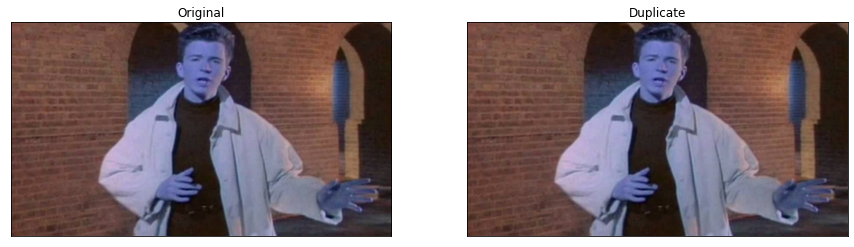

In [ ]:
for file_names in duplicates[:lendup]:    #plotting the original and duplicate image.
      fig = plt.figure(figsize=(15,15))
      plt.subplot(2,2,1)
      plt.imshow(cv2.imread(file_names[1]))
      plt.title('Original'), plt.xticks([]), plt.yticks([])
      plt.subplot(2,2,2)
      plt.imshow(cv2.imread(file_names[0]))
      plt.title('Duplicate'), plt.xticks([]), plt.yticks([])

##Observations:
1) To find similar images, computing hashes and comparing it with other hashes is more faster than computing the differnce of pixels between test image and other images.           
2) D hash is based on hashing the image data we get after finding the gradient intensity difference.         
3) Normally in hashing algorithms we are required to generate hashes as unique as possible, but in this case we have to tweak and do the reverse as, we waant to generate similar matching hashes for perceptually similar images.             
4) There are a few limitations of this algorithm, one of them being that it can't detect duplicate images which have been cropped.    

#Conclusion
1) Image hashing has come a long way but still there is a lot of room for improvement. Hashing algorithms which are crop,rotate,filter resistant have high demand but are just still in begining stages.        
2) There are some algorithms which use DCT (Discrete Cosine Transform) on images aand then hash the image, they are aaccurate but VERY slow as the time and space complexity is more.         
3) Big corporations like Google,Adobe,Apple etc use these algorithms to filter out pirated/copyrighted content.          
4) Not only that, Hashing is a powerful tool used by hotlines, Law Enforcement, Industry and other child protection organisations in the removal of violent and illict material. This is because it enables known items to be detected and removed without requiring them to be assessed again by an analyst.       
5) Using this type of algorithm does not violate users' privacy because the algorithm only detects matching hashes and does not 'see' any images which don't match the hash. Hash values are also not reversible, so cannot be used to recreate an image.

In [ ]:
! jupyter nbconvert --to html FINAL_SIP_Project.ipynb

[NbConvertApp] Converting notebook FINAL_SIP_Project.ipynb to html
[NbConvertApp] Writing 735869 bytes to FINAL_SIP_Project.html
